In [4]:
import os
import sys
import torch
import random
import warnings
import numpy as np
import torch.nn as nn

from PIL import Image
from torch import optim
from sklearn.utils import shuffle
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [17]:
def load_data(path):
    images, labels = [], []
    for dir in os.listdir(path):
        indir = os.path.join(path, dir)
        for file in os.listdir(indir):
            img_path = os.path.join(indir, file)
            image = Image.open(img_path)
            images.append(np.array(image))
            digit1 = int(img_path.split('_')[-1][0])
            digit2 = int(img_path.split('_')[-1][1])
            label = [0]*10
            label[digit1] = 1
            label[digit2] = 1
            labels.append(label)
    return images, labels

def display_images(images, labels, num=5):
    indices = random.sample(range(len(images)), num)
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, num, i+1)
        plt.imshow(images[idx], cmap='gray')
        plt.axis('off')
    plt.show()

def filter_data(x_train, y_train):
    images, labels = [], []
    for (x, y) in zip(x_train, y_train):
        if y.count(1) != 1:
            images.append(x)
            labels.append(y)
    return images, labels

In [18]:
# Load all the datasets
train_path = 'double_mnist_seed_123_image_size_64_64/train/'
x_train, y_train = load_data(train_path)

val_path = 'double_mnist_seed_123_image_size_64_64/val/'
x_valid, y_valid = load_data(val_path)

test_path = 'double_mnist_seed_123_image_size_64_64/test/'
x_test, y_test = load_data(test_path)

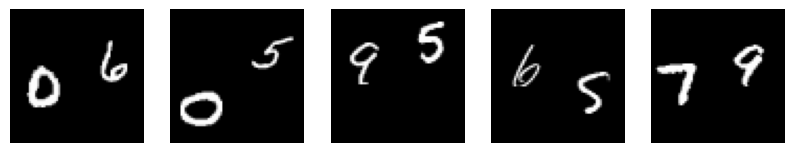

In [19]:
# Display the sample images and exclude images where same digit appears twice
display_images(x_train, y_train)
x_train, y_train = filter_data(x_train, y_train)
x_train, y_train = shuffle(x_train, y_train)

trainset = TensorDataset(torch.Tensor(x_train), torch.LongTensor(y_train))
valset = TensorDataset(torch.Tensor(x_valid), torch.LongTensor(y_valid))
testset = TensorDataset(torch.Tensor(x_test), torch.LongTensor(y_test))

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [12]:
class multiMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=10):
        super(multiMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        self.hidden_layers.extend([nn.Linear(hidden_sizes[i-1], hidden_sizes[i]) for i in range(1, len(hidden_sizes))])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        x = self.flatten(x)
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

In [13]:
def train(model, loss_func, optimizer, trainloader):
    n_epochs = 10
    for i in range(n_epochs):
        model.train()
        for (image, label) in trainloader:
            optimizer.zero_grad()
            output = model(image)
            loss = loss_func(output, label.float())
            loss.backward()
            optimizer.step()

def evaluate(model, dataloader):
    model.eval()
    threshold, hamming_dist = 0.5, 0
    with torch.no_grad():
        total = 0
        for (image, label) in dataloader:
            total += 1
            output = model(image)
            output = (output >= threshold).int()
            hamming_dist += 1 - hamming_loss(label, output)
    return hamming_dist / total

In [36]:
# MLP training on multi mnist dataset
input_size = 64*64
hidden_layers = [[64, 32], [128, 64, 32], [256, 128, 64], [128, 128, 128], [32, 64, 128]]

t = PrettyTable(['Hidden layers configuration', 'Train Accuracy', 'Val Accuracy'])
for hidden_size in hidden_layers:
    mlp = multiMLP(input_size, hidden_size)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp.parameters(), lr=0.0001)

    train(mlp, loss_func, optimizer, trainloader)
    t_accuracy = evaluate(mlp, trainloader)
    v_accuracy = evaluate(mlp, valloader)
    t.add_row([hidden_size, round(t_accuracy, 4), round(v_accuracy, 4)])
print(t)

+-----------------------------+----------------+--------------+
| Hidden layers configuration | Train Accuracy | Val Accuracy |
+-----------------------------+----------------+--------------+
|           [64, 32]          |     0.8772     |    0.7813    |
|        [128, 64, 32]        |     0.9198     |    0.8151    |
|        [256, 128, 64]       |     0.9484     |    0.8326    |
|       [128, 128, 128]       |     0.9242     |    0.815     |
|        [32, 64, 128]        |     0.8405     |    0.7509    |
+-----------------------------+----------------+--------------+


In [14]:
# define the cnn class for the multi mnist dataset
class multiCNN(nn.Module):
    def __init__(self, ks=(3, 3), p=1, rate=0.2):
        super(multiCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=ks, stride=1, padding=p),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=ks, stride=1, padding=p),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.dropout = nn.Dropout(p=rate)
        self.out = nn.Linear(16*16*32, 10)

    def forward(self, x):
        x = x.view(-1, 1, 64, 64)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 16*16*32)
        x = self.dropout(x)
        x = self.out(x)
        x = torch.sigmoid(x)
        return x

In [24]:
# CNN training on multi mnist dataset
padding = [1, 2]
dropout_rates = [0.2, 0.5]
kernel_sizes = [(3,3), (5,5)]
learn_rate = [0.001, 0.01, 0.1]

t = PrettyTable(['Learning rate', 'Dropout Rate', 'Kernel size', 'padding', 'Train Accuracy', 'Val Accuracy'])
for rate in learn_rate:
    for dr in dropout_rates:
        for (ks, p) in zip(kernel_sizes, padding):
            cnn = multiCNN(ks, p, dr)
            loss_func = nn.CrossEntropyLoss()
            optimizer = optim.Adam(cnn.parameters(), lr=rate)
            train(cnn, loss_func, optimizer, trainloader)
            t_accuracy = evaluate(cnn, trainloader)
            v_accuracy = evaluate(cnn, valloader)
            t.add_row([rate, dr, ks, p, round(t_accuracy, 4), round(v_accuracy, 4)])
print(t)

+---------------+--------------+-------------+---------+----------------+--------------+
| Learning rate | Dropout Rate | Kernel size | padding | Train Accuracy | Val Accuracy |
+---------------+--------------+-------------+---------+----------------+--------------+
|     0.001     |     0.2      |    (3, 3)   |    1    |     0.8688     |    0.8369    |
|     0.001     |     0.2      |    (5, 5)   |    2    |     0.8755     |    0.8484    |
|     0.001     |     0.5      |    (3, 3)   |    1    |     0.8125     |    0.7999    |
|     0.001     |     0.5      |    (5, 5)   |    2    |     0.8696     |    0.8409    |
|      0.01     |     0.2      |    (3, 3)   |    1    |     0.8772     |    0.8405    |
|      0.01     |     0.2      |    (5, 5)   |    2    |     0.8717     |    0.8319    |
|      0.01     |     0.5      |    (3, 3)   |    1    |     0.8462     |    0.8151    |
|      0.01     |     0.5      |    (5, 5)   |    2    |     0.8713     |    0.8284    |
|      0.1      |    

In [20]:
# Evaluate on the test dataset
mlp = multiMLP(64*64, [256, 128, 64])
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.0001)
train(mlp, loss_func, optimizer, trainloader)
mlp_accuracy = evaluate(mlp, testloader)

cnn = multiCNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
train(cnn, loss_func, optimizer, trainloader)
cnn_accuracy = evaluate(cnn, testloader)

print('Test Accuracy using MLP: {:.4f}'.format(mlp_accuracy))
print('Test Accuracy using CNN: {:.4f}'.format(cnn_accuracy))

Test Accuracy using MLP: 0.8362
Test Accuracy using CNN: 0.8858


In [6]:
# Load the permuted dataset
data = np.load("permuted_mnist.npz")
# print(data.files)

x_train, y_train = data["train_images"], data["train_labels"]
x_test, y_test = data["test_images"], data["test_labels"]
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

trainset = TensorDataset(torch.Tensor(x_train), torch.LongTensor(y_train))
valset = TensorDataset(torch.Tensor(x_valid), torch.LongTensor(y_valid))
testset = TensorDataset(torch.Tensor(x_test), torch.LongTensor(y_test))

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        self.hidden_layers.extend([nn.Linear(hidden_sizes[i-1], hidden_sizes[i]) for i in range(1, len(hidden_sizes))])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        x = self.flatten(x)
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output_layer(x)
        return x

In [7]:
def train_p(model, loss_func, optimizer, trainloader):
    n_epochs = 10
    for i in range(n_epochs):
        model.train()
        for (image, label) in trainloader:
            optimizer.zero_grad()
            output = model(image)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()

def evaluate_p(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for (image, label) in dataloader:
            output = model(image)
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    return correct / total

In [25]:
# MLP training on Permuted mnist dataset
input_size, output_size = 28*28, 10
hidden_layers = [[64, 32], [128, 64, 32], [256, 128, 64], [128, 128, 128], [32, 64, 128]]

t = PrettyTable(['Hidden layers configuration', 'Train Accuracy', 'Val Accuracy'])
for hidden_size in hidden_layers:
    mlp = MLP(input_size, hidden_size, output_size)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp.parameters(), lr=0.0001)

    train_p(mlp, loss_func, optimizer, trainloader)
    t_accuracy = evaluate_p(mlp, trainloader)
    v_accuracy = evaluate_p(mlp, valloader)
    t.add_row([hidden_size, round(t_accuracy, 4), round(v_accuracy, 4)])
print(t)

+-----------------------------+----------------+--------------+
| Hidden layers configuration | Train Accuracy | Val Accuracy |
+-----------------------------+----------------+--------------+
|           [64, 32]          |     0.886      |    0.8592    |
|        [128, 64, 32]        |     0.8947     |    0.8673    |
|        [256, 128, 64]       |     0.8975     |    0.8746    |
|       [128, 128, 128]       |     0.8969     |    0.8704    |
|        [32, 64, 128]        |     0.8781     |    0.8567    |
+-----------------------------+----------------+--------------+


In [9]:
# define the cnn class for permuted dataset
class CNN(nn.Module):
    def __init__(self, ks=(3, 3), p=1, rate=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=ks, stride=1, padding=p),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=ks, stride=1, padding=p),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.dropout = nn.Dropout(p=rate)
        self.out = nn.Linear(7*7*32, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 7*7*32)
        x = self.dropout(x)
        x = self.out(x)
        x = self.softmax(x)
        return x

In [31]:
# CNN training on the permuted mnist dataset
padding = [1, 2]
dropout_rates = [0.2, 0.5]
kernel_sizes = [(3,3), (5,5)]
learn_rate = [0.001, 0.0001, 0.00001]

t = PrettyTable(['Learning rate', 'Dropout Rate', 'Kernel size', 'padding', 'Train Accuracy', 'Val Accuracy'])
for rate in learn_rate:
    for dr in dropout_rates:
        for (ks, p) in zip(kernel_sizes, padding):
            cnn = CNN(ks, p, dr)
            loss_func = nn.CrossEntropyLoss()
            optimizer = optim.Adam(cnn.parameters(), lr=rate)
            train_p(cnn, loss_func, optimizer, trainloader)
            t_accuracy = evaluate_p(cnn, trainloader)
            v_accuracy = evaluate_p(cnn, valloader)
            t.add_row([rate, dr, ks, p, round(t_accuracy, 4), round(v_accuracy, 4)])
print(t)

+---------------+--------------+-------------+---------+----------------+--------------+
| Learning rate | Dropout Rate | Kernel size | padding | Train Accuracy | Val Accuracy |
+---------------+--------------+-------------+---------+----------------+--------------+
|     0.001     |     0.2      |    (3, 3)   |    1    |     0.0905     |    0.0897    |
|     0.001     |     0.2      |    (5, 5)   |    2    |     0.0905     |    0.0897    |
|     0.001     |     0.5      |    (3, 3)   |    1    |     0.1025     |    0.101     |
|     0.001     |     0.5      |    (5, 5)   |    2    |     0.0905     |    0.0897    |
|     0.0001    |     0.2      |    (3, 3)   |    1    |     0.9482     |    0.9357    |
|     0.0001    |     0.2      |    (5, 5)   |    2    |     0.8782     |    0.8691    |
|     0.0001    |     0.5      |    (3, 3)   |    1    |     0.9417     |    0.9331    |
|     0.0001    |     0.5      |    (5, 5)   |    2    |     0.9471     |    0.9383    |
|     1e-05     |    

In [26]:
# Evaluate on the test dataset
mlp = MLP(28*28, [256, 128, 64], 10)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.0001)
train_p(mlp, loss_func, optimizer, trainloader)
mlp_accuracy = evaluate_p(mlp, testloader)

cnn = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0001)
train_p(cnn, loss_func, optimizer, trainloader)
cnn_accuracy = evaluate_p(cnn, testloader)

print('Test Accuracy using MLP: {:.4f}'.format(mlp_accuracy))
print('Test Accuracy using CNN: {:.4f}'.format(cnn_accuracy))

Test Accuracy using MLP: 0.8489
Test Accuracy using CNN: 0.8719
